In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms.functional as F

try:
	import torch_dct as dct
except ImportError:
	import subprocess
	import sys
	subprocess.check_call([sys.executable, "-m", "pip", "install", "torch-dct"])
	import torch_dct as dct

In [2]:
EPSILON = 1e-6

In [3]:
def get_dct_matrix(N):
    """
    Computes the DCT-II matrix of size N x N.
    Equation: D[k, n] = c[k] * cos(pi/N * (n + 0.5) * k)
    """
    dct_m = np.zeros((N, N))
    for k in range(N):
        for n in range(N):
            if k == 0:
                alpha = np.sqrt(1 / N)
            else:
                alpha = np.sqrt(2 / N)
            dct_m[k, n] = alpha * np.cos((np.pi * (2 * n + 1) * k) / (2 * N))
    return torch.from_numpy(dct_m).float()

In [4]:
class DCTSpectralPool(nn.Module):
    def __init__(self, input_size, factor):
        """
        Args:
            input_size (int): The height/width of the square input image.
            factor (int): The downsampling factor (e.g., 2, 4, 8).
        """
        super().__init__()
        self.input_size = input_size
        self.output_size = input_size // factor
        self.factor = factor
        self.register_buffer('D_in', get_dct_matrix(input_size))
        self.register_buffer('D_out', get_dct_matrix(self.output_size))

    def forward(self, x, homomorphic=False):
        """
        x: (Batch, Channels, Height, Width)
        """
        batch, ch, h, w = x.shape
        if homomorphic:
            x = torch.log(x + EPSILON)
        x_freq = self.D_in @ x @ self.D_in.t()
        target_h, target_w = self.output_size, self.output_size
        x_freq_cropped = x_freq[:, :, :target_h, :target_w]
        x_pooled = self.D_out.t() @ x_freq_cropped @ self.D_out
        if homomorphic:
            x_pooled = torch.exp(x_pooled) - EPSILON
        return x_pooled, x_freq, x_freq_cropped

In [5]:
def process_and_visualize_dct_spectral_pooling(image_path, factors=[1, 2, 4, 8]):
    try:
        if image_path.startswith('http'):
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content)).convert('L')
        else:
            img = Image.open(image_path).convert('L')
    except:
        print("Could not load image. Using random noise.")
        img = Image.fromarray(np.random.randint(0, 255, (256, 256), dtype=np.uint8))
    BASE_SIZE = 256
    img = img.resize((BASE_SIZE, BASE_SIZE))
    x = F.to_tensor(img).unsqueeze(0)
    plt.figure(figsize=(15, 8))
    plt.subplot(2, len(factors) + 1, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{BASE_SIZE}x{BASE_SIZE}")
    plt.axis('off')
    for i, f in enumerate(factors):
        pool_layer = DCTSpectralPool(BASE_SIZE, f)
        with torch.no_grad():
            out_spatial, out_freq_full, out_freq_crop = pool_layer(x, homomorphic=False)
        freq_viz = torch.log(torch.abs(out_freq_crop) + 1e-6)
        freq_viz = freq_viz[0, 0].numpy()
        plt.subplot(2, len(factors) + 1, i + 2)
        plt.imshow(freq_viz, cmap='inferno')
        plt.title(f"DCT Crop\nFactor {f}:1")
        plt.axis('off')
        spatial_viz = out_spatial[0, 0].numpy()
        plt.subplot(2, len(factors) + 1, len(factors) + 1 + i + 2)
        plt.imshow(spatial_viz, cmap='gray')
        output_res = BASE_SIZE // f
        plt.title(f"Pooled Output\n{output_res}x{output_res}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

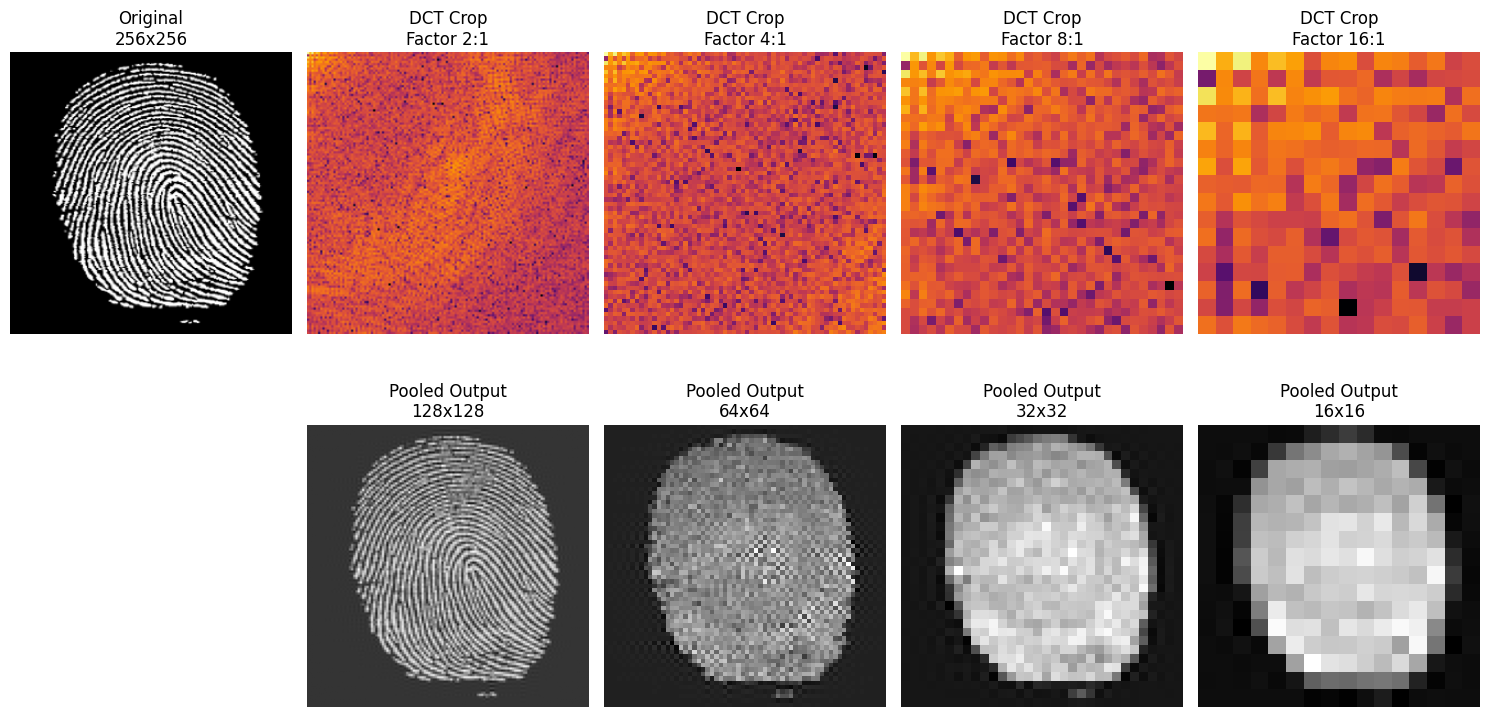

In [6]:
# image_path = "thumb_fingerprint.png"
image_path = "inverted_fingerprint.png"
process_and_visualize_dct_spectral_pooling(image_path, factors=[2, 4, 8, 16])

In [7]:
def process_and_visualize_maxpool(image_path, factors=[1, 2, 4, 8]):
    try:
        if image_path.startswith('http'):
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content)).convert('L')
        else:
            img = Image.open(image_path).convert('L')
    except Exception as e:
        print(f"Could not load image. Error: {e}")
        print("Using random noise.")
        img = Image.fromarray(np.random.randint(0, 255, (256, 256), dtype=np.uint8))
    BASE_SIZE = 256
    img = img.resize((BASE_SIZE, BASE_SIZE))
    x = F.to_tensor(img).unsqueeze(0) 
    plt.figure(figsize=(15, 4))
    plt.subplot(1, len(factors) + 1, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{BASE_SIZE}x{BASE_SIZE}")
    plt.axis('off')
    for i, f in enumerate(factors):
        if f == 1:
            out_spatial = x
        else:
            pool_layer = nn.MaxPool2d(kernel_size=f, stride=f)
            out_spatial = pool_layer(x)
        spatial_viz = out_spatial[0, 0].numpy()
        plt.subplot(1, len(factors) + 1, i + 2)
        plt.imshow(spatial_viz, cmap='gray')
        output_res = BASE_SIZE // f
        plt.title(f"Max Pool\nFactor {f} ({output_res}x{output_res})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

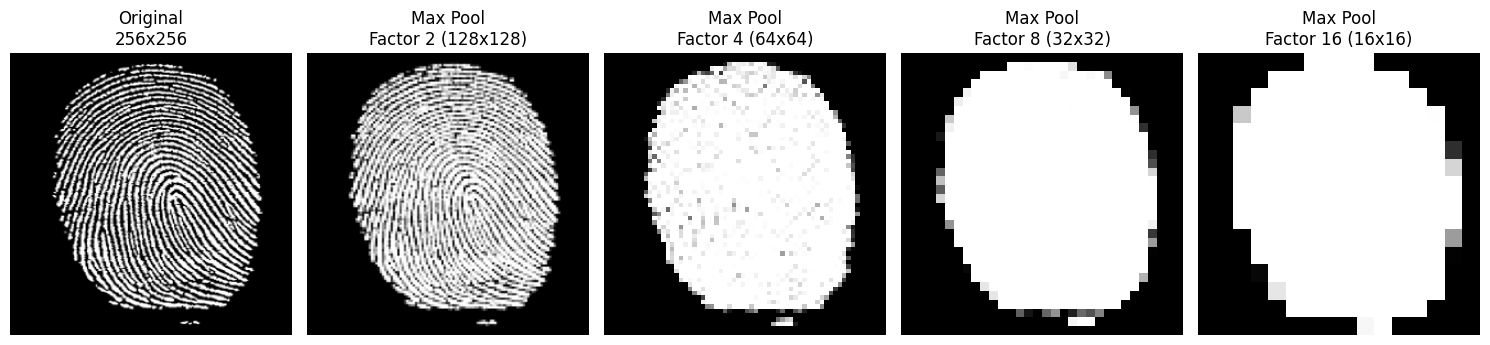

In [8]:
process_and_visualize_maxpool(image_path, factors=[2, 4, 8, 16])

In [9]:
def process_and_visualize_avgpool(image_path, factors=[1, 2, 4, 8]):
    try:
        if image_path.startswith('http'):
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content)).convert('L')
        else:
            img = Image.open(image_path).convert('L')
    except Exception as e:
        print(f"Could not load image. Error: {e}")
        print("Using random noise.")
        img = Image.fromarray(np.random.randint(0, 255, (256, 256), dtype=np.uint8))
    BASE_SIZE = 256
    img = img.resize((BASE_SIZE, BASE_SIZE))
    x = F.to_tensor(img).unsqueeze(0) 
    plt.figure(figsize=(15, 4))
    plt.subplot(1, len(factors) + 1, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{BASE_SIZE}x{BASE_SIZE}")
    plt.axis('off')
    for i, f in enumerate(factors):
        if f == 1:
            out_spatial = x
        else:
            pool_layer = nn.AvgPool2d(kernel_size=f, stride=f)
            out_spatial = pool_layer(x)
        spatial_viz = out_spatial[0, 0].numpy()
        plt.subplot(1, len(factors) + 1, i + 2)
        plt.imshow(spatial_viz, cmap='gray')
        output_res = BASE_SIZE // f
        plt.title(f"Average Pool\nFactor {f} ({output_res}x{output_res})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

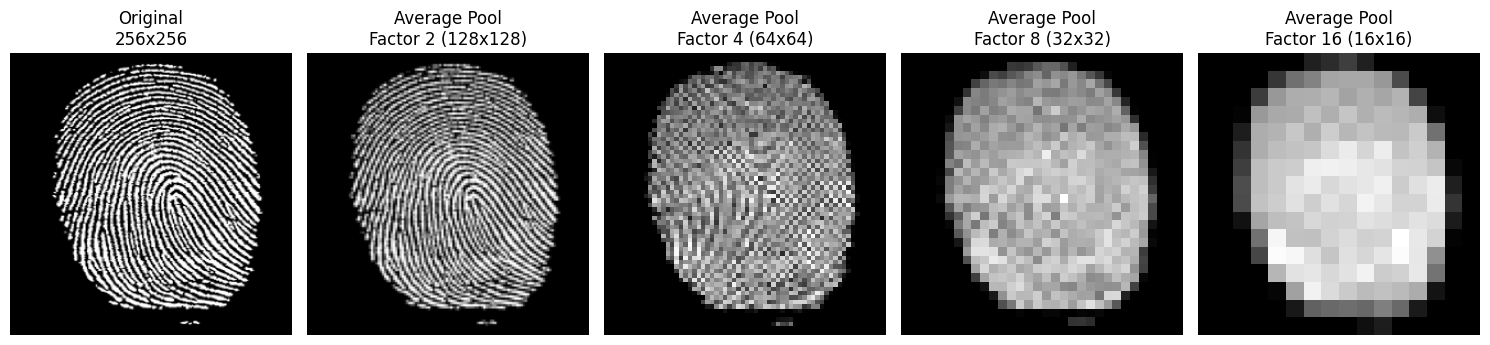

In [10]:
process_and_visualize_avgpool(image_path, factors=[2, 4, 8, 16])

In [11]:
def process_and_visualize_dct_spectral_pooling_mask_no_crop(image_path, factors=[1, 2, 4, 8]):
    try:
        if image_path.startswith('http'):
            response = requests.get(image_path)
            img = Image.open(BytesIO(response.content)).convert('L')
        else:
            img = Image.open(image_path).convert('L')
    except Exception as e:
        print(f"Could not load image. Error: {e}")
        print("Using random noise.")
        img = Image.fromarray(np.random.randint(0, 255, (256, 256), dtype=np.uint8))

    BASE_SIZE = 256
    img = img.resize((BASE_SIZE, BASE_SIZE))
    x = F.to_tensor(img).unsqueeze(0)
    dct_m = get_dct_matrix(BASE_SIZE)
    idct_m = dct_m.t()
    plt.figure(figsize=(15, 8))
    plt.subplot(2, len(factors) + 1, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{BASE_SIZE}x{BASE_SIZE}")
    plt.axis('off')
    for i, f in enumerate(factors):
        img_tensor = x.squeeze()
        freq_domain = torch.matmul(dct_m, torch.matmul(img_tensor, dct_m.t()))
        keep_size = BASE_SIZE // f
        masked_freq_domain = torch.zeros_like(freq_domain)
        masked_freq_domain[0:keep_size, 0:keep_size] = freq_domain[0:keep_size, 0:keep_size]
        out_spatial = torch.matmul(idct_m, torch.matmul(masked_freq_domain, idct_m.t()))
        freq_viz = torch.log(torch.abs(masked_freq_domain) + 1e-6)
        freq_viz = freq_viz.numpy()
        plt.subplot(2, len(factors) + 1, i + 2)
        plt.imshow(freq_viz, cmap='inferno')
        plt.title(f"Masked Freq\nFactor {f}:1")
        plt.axis('off')
        spatial_viz = out_spatial.numpy()
        plt.subplot(2, len(factors) + 1, len(factors) + 1 + i + 2)
        plt.imshow(spatial_viz, cmap='gray')
        plt.title(f"Reconstructed\n{BASE_SIZE}x{BASE_SIZE}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

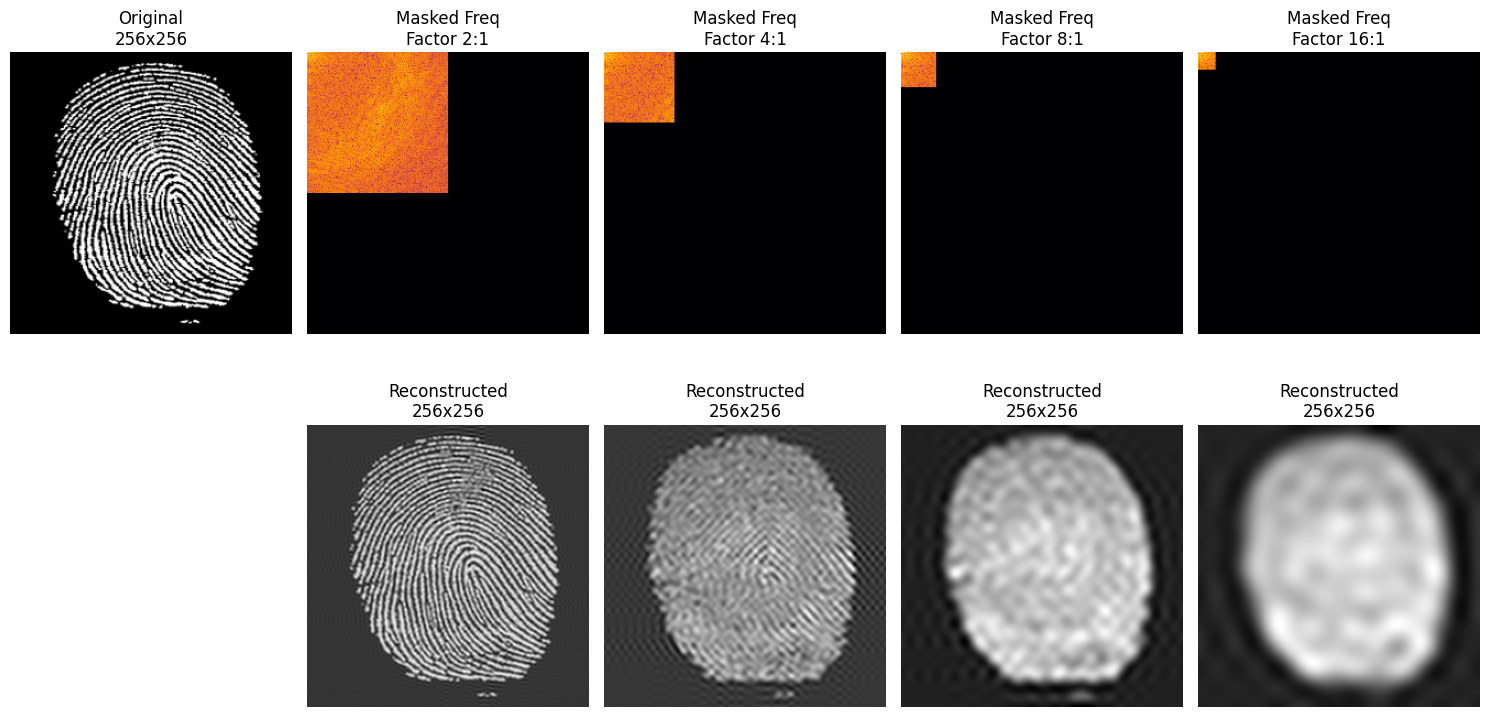

In [12]:
process_and_visualize_dct_spectral_pooling_mask_no_crop(image_path, factors=[2, 4, 8, 16])

Benchmarking on: cuda
Size (N)   | FFT (ms)   | Linear (ms) | Speedup   
--------------------------------------------------
16         | 0.0967     | 0.0102     | 9.45      x
32         | 0.1012     | 0.0152     | 6.66      x
64         | 0.1319     | 0.0140     | 9.40      x
128        | 0.1361     | 0.0137     | 9.96      x
256        | 0.1288     | 0.0167     | 7.72      x
512        | 0.1097     | 0.0194     | 5.66      x
1024       | 0.1246     | 0.0461     | 2.70      x
2048       | 0.1169     | 0.1340     | 0.87      x
4096       | 0.1212     | 0.4794     | 0.25      x


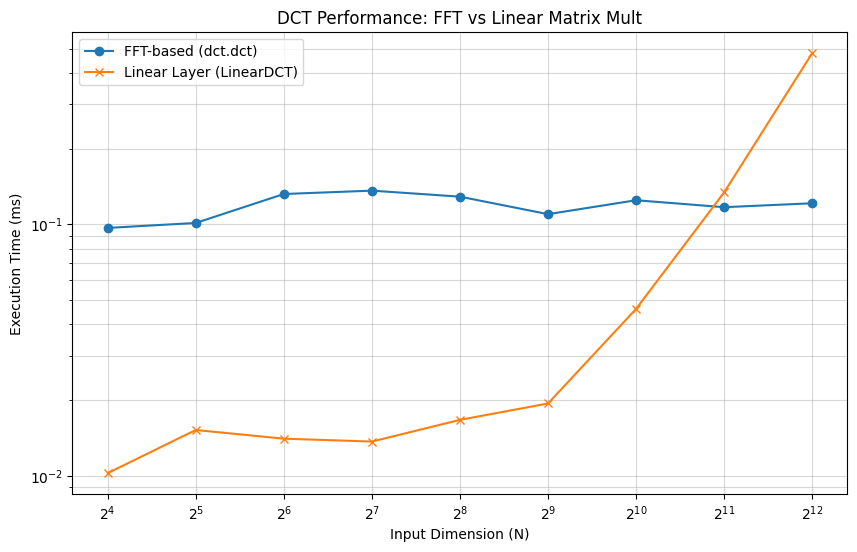

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Benchmarking on: {device}")
sizes = [2**i for i in range(4, 13)] 
batch_size = 128
num_repeats = 100
times_fft = []
times_linear = []

print(f"{'Size (N)':<10} | {'FFT (ms)':<10} | {'Linear (ms)':<10} | {'Speedup':<10}")
print("-" * 50)

for N in sizes:
    x = torch.randn(batch_size, N, device=device)
    for _ in range(10): 
        _ = dct.dct(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()
    for _ in range(num_repeats):
        _ = dct.dct(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    avg_fft = (time.time() - start) / num_repeats * 1000
    linear_layer = dct.LinearDCT(N, type='dct').to(device)
    for _ in range(10):
        _ = linear_layer(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()
    for _ in range(num_repeats):
        _ = linear_layer(x)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    avg_linear = (time.time() - start) / num_repeats * 1000
    times_fft.append(avg_fft)
    times_linear.append(avg_linear)
    speedup = avg_fft / avg_linear
    print(f"{N:<10} | {avg_fft:<10.4f} | {avg_linear:<10.4f} | {speedup:<10.2f}x")

plt.figure(figsize=(10, 6))
plt.plot(sizes, times_fft, label='FFT-based (dct.dct)', marker='o')
plt.plot(sizes, times_linear, label='Linear Layer (LinearDCT)', marker='x')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Input Dimension (N)')
plt.ylabel('Execution Time (ms)')
plt.title('DCT Performance: FFT vs Linear Matrix Mult')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

Size (N)   | FFT (MB)   | Linear (MB)
----------------------------------------
32         | 0.05       | 0.00      
64         | 0.10       | 0.03      
128        | 0.19       | 0.09      
256        | 0.38       | 0.31      
512        | 0.76       | 1.12      
1024       | 1.51       | 4.25      
2048       | 3.02       | 16.50     
4096       | 6.05       | 65.00     
8192       | 12.09      | 258.00    


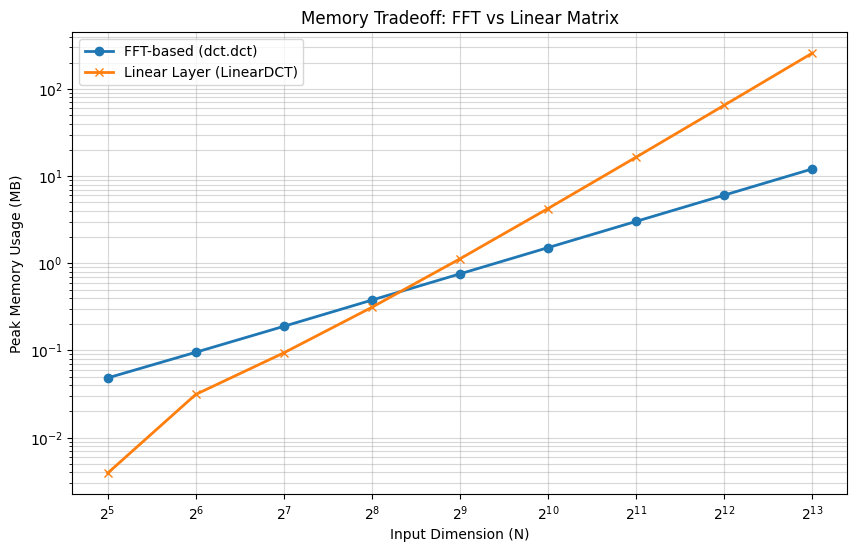

In [14]:
if not torch.cuda.is_available():
    print("This script requires a GPU to strictly measure VRAM usage.")
    exit()
device = torch.device('cuda')
sizes = [2**i for i in range(5, 14)]
batch_size = 64
mem_fft = []
mem_linear = []
print(f"{'Size (N)':<10} | {'FFT (MB)':<10} | {'Linear (MB)':<10}")
print("-" * 40)
for N in sizes:
    x = torch.randn(batch_size, N, device=device)
    torch.cuda.reset_peak_memory_stats(device)
    baseline_mem = torch.cuda.memory_allocated(device)
    y = dct.dct(x)
    peak_mem = torch.cuda.max_memory_allocated(device)
    mem_usage_mb = (peak_mem - baseline_mem) / 1024**2
    mem_fft.append(mem_usage_mb)
    del y
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    baseline_mem = torch.cuda.memory_allocated(device)
    linear_layer = dct.LinearDCT(N, type='dct').to(device)
    y = linear_layer(x)
    peak_mem = torch.cuda.max_memory_allocated(device)
    mem_usage_mb = (peak_mem - baseline_mem) / 1024**2
    mem_linear.append(mem_usage_mb)
    del linear_layer, y
    torch.cuda.empty_cache()
    print(f"{N:<10} | {mem_fft[-1]:<10.2f} | {mem_linear[-1]:<10.2f}")

plt.figure(figsize=(10, 6))
plt.plot(sizes, mem_fft, label='FFT-based (dct.dct)', marker='o', linewidth=2)
plt.plot(sizes, mem_linear, label='Linear Layer (LinearDCT)', marker='x', linewidth=2)
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('Input Dimension (N)')
plt.ylabel('Peak Memory Usage (MB)')
plt.title('Memory Tradeoff: FFT vs Linear Matrix')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()